#### Learning Objectives
By the end of this lesson, you will be able to..

- Incorporate transformed variables into linear and logistic regression models.
- Recognize when a log transformation is appropriate.
- Use regularization to reduce overfitting.
- Distinguish between time-series and cross-sectional data.
- Describe time-series data in terms of trend, seasonality, and noise.
- Explain how train/test splits need to be performed differently for time-series data.

# Advanced Topics in Regression

## Using Transformed Variables in Regression Models

Linear regression creates a model that is linear in the features that you pass into it.

In [31]:
from pathlib import Path
from sklearn.linear_model import LinearRegression


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [29]:
mammals_path = Path('.', 'data', 'mammals.txt')
cols = ['brain','body']
mammals = pd.read_csv(mammals_path, sep='\t', names=cols, header=0)
mammals = mammals.loc[mammals.loc[:, 'body'] < 200, :].sort_values('body')
mammals.head()

,brain,body
13,0.005,0.14
39,0.010,0.25
19,0.023,0.30
54,0.048,0.33
38,0.023,0.40


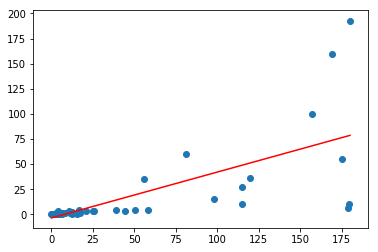

In [41]:
feature_cols = ['body']
X = mammals.loc[:, feature_cols]
y = mammals.loc[:, 'brain']

linreg = LinearRegression()
linreg.fit(X, y)
y_fit = linreg.predict(X)
plt.plot(X.values, y_fit, color='red')
plt.scatter(X.values, y);

But it can capture non-linear relationships with your original features if you give it non-linear transformations of those features.

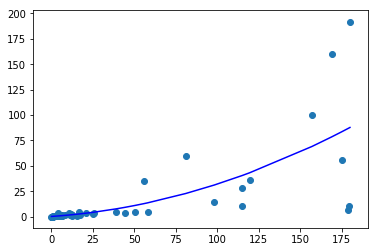

In [40]:
# Re-run the regression with an additional squared term


mammals["body_size_squared"] = mammals.loc[:,"body"]**2


feature_cols = ["body", "body_size_squared"]

X = mammals.loc[:, feature_cols]
y = mammals.loc[:, "brain"]

linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)

plt.plot(mammals.loc[:, 'body'], y_pred, color="blue" )
plt.scatter(mammals.loc[:, "body"], y)


# # Instructor's Answer
# feature_cols = ['body', 'body_squared']
# X = mammals.loc[:, feature_cols]
# y = mammals.loc[:, 'brain']

# linreg = LinearRegression()
# linreg.fit(X, y)
# y_pred = linreg.predict(X)

# plt.plot(mammals.loc[:, 'body'].values, y_pred, color='red')
# plt.scatter(mammals.loc[:, 'body'], y);

### Polynomial Terms

A polynomial function of x has the form $c_0 + c_1x + c_2x^2 + c_3x^3 + \ldots$.

If you give a linear regression model $x$, $x^2$, and $x^3$ as features, for instance, it will find the $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ that minimizes mean-squared error for using $\beta_0 + \beta_1x + \beta_2x^2 + \beta_3x^3$ to predict $y$.

It can always recover simple linear regression by setting the coefficients on the higher-order terms to 0, so adding these higher-order terms only increases the set of relationships that the model can capture.

**Exercise.**

- How does adding higher-order polynomial terms as inputs to a linear regression model affect its bias and variance?

**Every additional polynomial term gives your model an additional chance to change directions.**

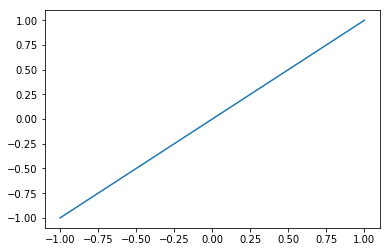

In [45]:
# first-order
x = np.linspace(-1, 1, 100)
plt.plot(x, x);

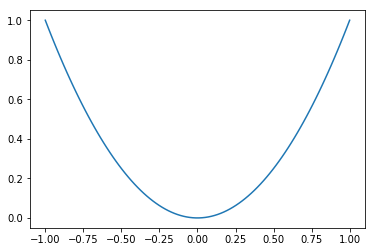

In [46]:
# second-order
plt.plot(x, x**2);

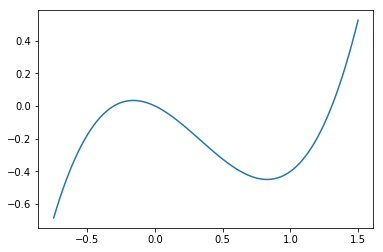

In [47]:
# third-order
x = np.linspace(-.75, 1.5, 100)
plt.plot(x, -.4*x-x**2+x**3);

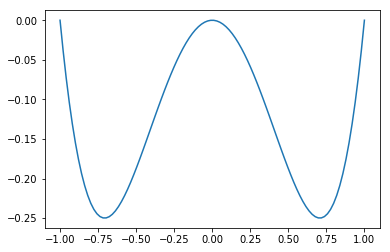

In [48]:
# fourth-order
x = np.linspace(-1, 1, 100)
plt.plot(x, -x**2+x**4);

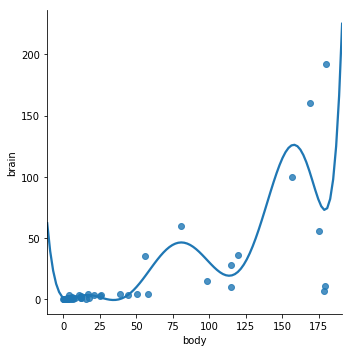

In [49]:
# Too many polynomial terms leads to overfitting
fig = sns.lmplot(x='body', y='brain', data=mammals, ci=None, order=8);

/home/david/Apps/Dev/Conda3/lib/python3.6/site-packages/seaborn/regression.py:237: RankWarning: Polyfit may be poorly conditioned
  reg_func = lambda _x, _y: np.polyval(np.polyfit(_x, _y, order), grid)


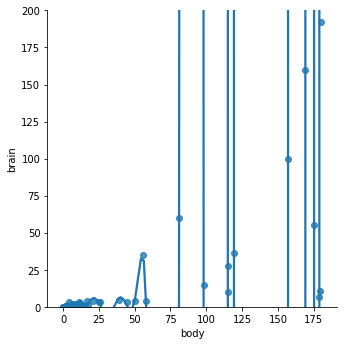

In [50]:
# An (n-1)-order polynomial can always fit n data points perfectly.
# Definitely overfitting!
fig = sns.lmplot(x='body', y='brain', data=mammals, ci=None, order=50);
ax = fig.axes
ax[0,0].set_ylim(0, 200);

**Including multiple transformations of one variable complicates coefficient interpretation.**

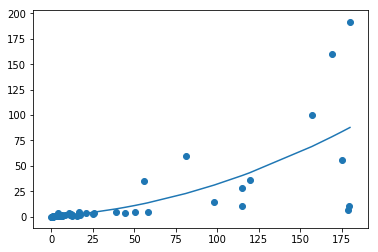

In [51]:
mammals.loc[:, 'body_squared'] = mammals.loc[:, 'body']**2

X = mammals.loc[:, ['body', 'body_squared']]
y = mammals.loc[:, 'brain']

linreg = LinearRegression()
linreg.fit(X, y)
y_fit = linreg.predict(X)

plt.plot(mammals.loc[:, 'body'].values, y_fit)
plt.scatter(mammals.loc[:, 'body'], y);

In [52]:
print(linreg.intercept_)
print(linreg.coef_)

0.131987305736
[ 0.10843153  0.00210168]


**Exercise.**

- Write down the fitted model we just created.

- How would you normally interpret the coefficient on `body` in this model? Why doesn't that interpretation work in this case?

**sklearn has a "transformer" that generates polynomial terms**

In [56]:
# sklearn transformers have the same interface as "estimators" (models)
# except that you fit them on features and use them to transform features,
# rather than fitting them on features and a target and using them to predict
# target values.
from sklearn.preprocessing import PolynomialFeatures

X = mammals.loc[:, ["body"]]
pf = PolynomialFeatures(degree=3, include_bias=False)
pf.fit(X)
pf.transform(X)

array([[  1.40000000e-01,   1.96000000e-02,   2.74400000e-03],
       [  2.50000000e-01,   6.25000000e-02,   1.56250000e-02],
       [  3.00000000e-01,   9.00000000e-02,   2.70000000e-02],
       [  3.30000000e-01,   1.08900000e-01,   3.59370000e-02],
       [  4.00000000e-01,   1.60000000e-01,   6.40000000e-02],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  1.20000000e+00,   1.44000000e+00,   1.72800000e+00],
       [  1.90000000e+00,   3.61000000e+00,   6.85900000e+00],
       [  2.40000000e+00,   5.76000000e+00,   1.38240000e+01],
       [  2.50000000e+00,   6.25000000e+00,   1.56250000e+01],
       [  2.60000000e+00,   6.76000000e+00,   1.75760000e+01],
       [  3.00000000e+00,   9.00000000e+00,   2.70000000e+01],
       [  3.50000000e+00,   1.22500000e+01,   4.28750000e+01],
       [  3.90000000e+00,   1.52100000e+01,   5.93190000e+01],
       [  4.00000000e+00,   1.60000000e+01,   6.4000000

**Exercise.**

In [ ]:
lr = LinearRegression()
lr.fit(X,y)


Use the Boston housing data for the exercises below.

In [61]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.DataFrame(boston.target, columns=['MEDV'])
boston = pd.concat([X, y], axis=1)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


- Create a linear regression model for MEDV against DIS with no higher-order polynomial terms.

In [78]:

X = boston.loc[:,["DIS"]]
y = boston.loc[:,"MEDV"]

lrb = LinearRegression()

lrb.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Create a linear regression model for y against X polynomial terms up to and including degree seven.

In [102]:
from sklearn.preprocessing import PolynomialFeatures


pf = PolynomialFeatures(degree=7, include_bias=False)
pf.fit(X)
X7 = pf.transform(X)

lr_boston7 = LinearRegression()
lr_boston7.fit(X7, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Use 5-fold cross-validation to choose the polynomial order between 1 and 10 that gives the best results in terms of MSE on held-out data. *Hint*: use `sklearn.model_selection.cross_val_score`.

In [109]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=boston.shape[0], shuffle=True)


for poly_degree in range(1,11):
    pf = PolynomialFeatures(degree=poly_degree, include_bias=False)
    pf.fit(X)
    X_poly = pf.transform(X)
    #X_poly = pf.fit_transform(X)
    
    
    lr = LinearRegression()
    score = np.mean(-cross_val_score(lr, X_poly, y, cv=kf, scoring='neg_mean_squared_error'))
    print(poly_degree, score)
    


1 79.7590162997
2 77.3361056078
3 76.6815420169
4 77.2719554429
5 85.2018180338
6 84.2962114356
7 672.589762104
8 1802.91994731
9 161.331409667
10 525.404125554


- **Bonus:** Create a model with $DIS$ and $DIS^{-1}$ as features and score it using 5-fold cross-validation.

- **Bonus:** Create line plots of your models' fitted values as a function of DIS and overlay them on scatterplots of MEDV against DIS.

**Notes.**

- In statistics, it is extremely unusual to use more than a third-order polynomial.
- Higher-order polynomials are more common in machine learning, where the emphasis is on predictive accuracy rather than understanding.
- It would be unusual to use a polynomial term without including all lower-order polynomial terms.
- In addition to polynomial terms (with positive integer exponents), it can also be beneficial to include terms with negative exponents (e.g. $x^{-1}=1/x$) and/or fractional exponents (e.g. $x^{1/2}=\sqrt{X}$).

### Interaction Terms

Sometimes the significance of one feature depends on the value of another feature.

For instance, perhaps median housing prices increase as you get closer to a major employment center *unless crime is high around that area*.

We can model these kinds of "interaction effects" by including the *products* of the interacting variables as features in our models.

For example:

$$MEDV = \beta_0 + \beta_1 * DIS + \beta_2 * CRIM + \beta_{12} (DIS * CRIM)$$

In [ ]:
# Implement the model above


**Exercise.** Write down the fitted model we just created.

In [ ]:
# check descriptive stats


**Recall the usual interpretation of the coefficient on DIS:** how much the model's prediction for MEDV changes with a one-unit increase in DIS, all else being equal (i.e. for a particular value of CRIM).

**With interaction terms, interpreting the coefficients for a feature DIS requires specifying particular values for the interacting variables.**

For instance, if CRIM is fixed at its 25th percentile value of 0.082, we get

$MEDV = 22.62 + 0.48 * DIS + 0.467 * CRIM - 0.527 (DIS * CRIM)$

$MEDV = 22.62 + 0.48 * DIS + 0.467 * 0.082 - 0.527 (DIS * 0.082)$

$MEDV = 22.62 + 0.48 * DIS + 0.038 - 0.043 * DIS$

$MEDV = 22.658 + 0.437 * DIS$

So **at CRIM=.082**, the model's prediction for MEDV increases by .437 when DIS increases by one. It's better on average to be close to employment centers when crime is low.

The story is different when CRIM has its 75th percentile value of 3.64:

$MEDV = 22.62 + 0.48 * DIS + 0.467 * CRIM - 0.527 (DIS * CRIM)$

$MEDV = 22.62 + 0.48 * DIS + 0.467 * 3.64 - 0.527 (DIS * 3.64)$

$MEDV = 22.62 + 0.48 * DIS + 1.70 - 1.92 * DIS$

$MEDV = 24.32 -1.44 * DIS$

**At CRIM=3.64**, the model's prediction for MEDV *decreases* by 1.44 when DIS increases by one. It's better on average to be farther from employment centers when crime is high.

**Exercise.**

- How does adding interaction terms affect a model's bias and variance?

- Using 5-fold cross-validation, calculate the MSE for a model predicting MEDV from DIS and CRIM without an interaction term. *Hint*: use sklearn.model_selection.cross_val_score

- Using 5-fold cross-validation, calculate the MSE for a model predicting MEDV from DIS and CRIM with an interaction term. *Hint*: use sklearn.model_selection.cross_val_score

### Log Transformations

When your data is very skewed, try a log transformation.

Because we applied a log transformation to $y$ as well as $x$, we need to be careful about how we interpret the MSE values.

In [ ]:
# Train and score a linear model in the original space.
# This model isn't overfitting significantly, so let's not
# worry about a train/test split.


In [ ]:
# Train and score a linear model in the log-transformed space.
# This model isn't overfitting significantly, so let's not
# worry about a train/test split.


Not a fair comparison! MSE for the second model is in log-space.

In [ ]:
# Get MSE for the log-log model in the original space


**What's going on?**

In [ ]:
plt.scatter(X.values, y);
plt.plot(X, np.exp(y_pred_log));

In [ ]:
plt.scatter(X.values, y);
plt.plot(X, y_pred);

The model that we fit in log-log space is getting killed by the points in the top-right:

- MSE punishes large errors.
- Errors that are large in the original space don't look so large in log-log space, so the model doesn't focus on them as much as it "should."

The log-log model is still better in at least two respects:

- It conveys more understanding: modeling log of brain size as a linear function of log of body size plus random noise seems to capture what is really going on.
- It makes better predictions in terms of MAE.

In [ ]:
# Calculate MAE for the original and log-log models


**Notes**

- A log-transformed variable typically replaces the original variable in a regression analysis, unlike a polynomial term.
- You can apply a log transformation to any combination of your features and your target variable.

### Summary

- Linear regression *can* capture non-linear relationships *when you provide the appropriate non-linear transformations*.
- Every polynomial term you add allows your model to change directions once.
- Log transformations are awesome for skewed variables.

## Regularization

<a id="bonus-material-regularization"></a>
### Why Regularize?

Recall this overly complicated model:

In [ ]:
# Too many polynomial terms leads to overfitting
fig = sns.lmplot(x='body', y='brain', data=mammals, ci=None, order=8);

One way to make this model behave in a more reasonable way is to reduce the number of features we give it.

Another way is to *make it pay to use those features*. This approach is called **regularization**.

<a id="how-does-regularization-work"></a>
### How Does Regularization Work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which minimizes the residual sum of squares (RSS).

For a regularized linear regression model, we minimize the sum of RSS and a "penalty term" that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the number of features.
- $\beta_j$ is a model coefficient.
- $\alpha$ is a tuning parameter:
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and Ridge Path Diagrams

A larger alpha (toward the left of each diagram) results in more regularization:

- Lasso regression shrinks coefficients all the way to zero, thus removing them from the model.
- Ridge regression shrinks coefficients toward zero, but they essentially never reach zero.

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](./assets/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
### Advice for Applying Regularization

**Features should be standardized** so that the penalty is not sensitive to the scale of the variables.

**How should you choose between lasso regression and ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of colinearity in your model.
- If model performance is your primary concern, it is best to try both.
- Elastic net regression is a combination of lasso regression and ridge regression.

<a id="ridge-regression"></a>
### Example

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [ ]:
bikes_path = Path('.', 'data', 'bikeshare.csv')
bikes = pd.read_csv(bikes_path, index_col='datetime', parse_dates=True)
bikes_dummies = pd.get_dummies(bikes, columns=['season']).drop('season_1', axis=1)

In [ ]:
# Include dummy variables for season in the model.


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# Fit a Ridge Regression model with alpha=0 (equivalent to linear regression)


In [ ]:
# Coefficients for a non-regularized linear regression


Be careful in interpreting these coefficients, because they are related to the *normalized* versions of the input variables.

In [ ]:
# Try alpha=0.1.


In [ ]:
# Examine the coefficients.


Notice that the model tries to spread the coefficients more evenly because the squared term particularly punishes large deviations from zero.

In [ ]:
# Try Lasso with alpha=0.1


In [ ]:
# Examine the coefficients.


# Time Series Data

## What Is Time Series Data?

**Cross-Sectional Data**

<img src="./assets/cross_sectional_data.png" width=400></img>

Data is collected at a single point in time for each individual.

**Time-Series/Longitudinal Data**

<img src="./assets/time_series_data.png" width=400></img>

Data for the same variables is collected over time for the same individuals.

**Exercise.**

/poll "Which of the data sets that we have worked with so far contain time series data? (Select as many as apply.)" "bikes" "grad school admissions" "titanic" "ufo" "drinks" "boston housing" "nba" "mammals"

## Trends, Seasonality, and Noise

Google searches for "data science" show a strong increasing trend over the last five years:

![](./assets/data_science.png)

Google searches for "gingerbread house" show strong annual seasonality:

![](./assets/gingerbread_house.png)

Google searches for "iphone" show both trend and seasonality:

![](./assets/iphone.png)

**Exercise.**

Go to https://trends.google.com/trends/ and search for a term that interests you. Post it on Slack with a sentence or two about any trend or seasonality that it exhibits.

## Train/Test Split with Time Series Data

All training data come from before all test data -- your model should not be peeking into the future!

# Practice

Work on the practice notebooks from Unit 3 in pairs using the driver/navigator approach. One person (the "driver") writes the code (sharing his or her screen) while the other person (the "navigator") continually makes suggestions and reviews the code. The driver should talk about what he or she is doing, ask for input, and generally keep the navigator engaged.

We will switch driver/navigator roles when are time is halfway up.

Pick a notebook you haven't worked on yet if possible, especially when you are the driver. If you are the navigator for a notebook you have already worked on, don't pull out your code. Let your partner take the lead and give feedback on the direction they take.

# Projects

- Final Project Pt 3 due today
- Unit Project 3 (optional) due next Thurs.

# Questions?

```
=========================================
@channel
Exit Ticket: https://goo.gl/forms/OUw4gyTiRKMOTI3t2        

#feedback
=========================================
```